In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import reuters
import random
import matplotlib.pyplot as plt

# Load the Reuters corpus
sentences = reuters.sents()

# Initialize classifiers
vectorizer = CountVectorizer()
classifier_nb = MultinomialNB()
classifier_rf = RandomForestClassifier()
classifier_lr = LogisticRegression()

# Function to concatenate multiple consecutive sentences into one text
def concatenate_sentences(sentences_list, num_sentences):
    concatenated_text = ' '.join([' '.join(sent) for sent in sentences_list[:num_sentences]])
    return concatenated_text

# Randomly select a subset of documents from the Reuters corpus
random_indices = random.sample(range(len(sentences)), 150)
text_data = [concatenate_sentences(sentences[idx:idx+6], 6) for idx in random_indices]

# Generate random target labels
target = [random.choice(["AI generated", "Human generated"]) for _ in range(len(text_data))]

# Train classifiers
feature_vectors = vectorizer.fit_transform(text_data)
classifier_nb.fit(feature_vectors, target)
classifier_rf.fit(feature_vectors, target)
classifier_lr.fit(feature_vectors, target)

# Function to detect AI ensemble probability with a lower threshold
def detect_ai_ensemble(text, threshold=40):
    input_vector = vectorizer.transform([text])
    nb_probability = classifier_nb.predict_proba(input_vector)[0][1]
    rf_probability = classifier_rf.predict_proba(input_vector)[0][1]
    lr_probability = classifier_lr.predict_proba(input_vector)[0][1]
    
    ensemble_probability = (nb_probability + rf_probability + lr_probability) / 3
    is_ai_generated = ensemble_probability >= threshold
    return ensemble_probability * 100, is_ai_generated
class Node:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

class BinaryTree:
    def __init__(self):
        self.root = None

    def insert(self, data):
        if self.root is None:
            self.root = Node(data)
        else:
            self._insert_recursively(self.root, data)

    def _insert_recursively(self, node, data):
        if data[1] < node.data[1]:
            if node.left is None:
                node.left = Node(data)
            else:
                self._insert_recursively(node.left, data)
        elif data[1] > node.data[1]:
            if node.right is None:
                node.right = Node(data)
            else:
                self._insert_recursively(node.right, data)


# Building the binary tree with the modified function
def build_tree_from_text_with_threshold(text_data, target):
    tree = BinaryTree()
    for text, label in zip(text_data, target):
        ai_percentage, is_ai_generated = detect_ai_ensemble(text)
        if is_ai_generated:
            tree.insert((text, ai_percentage, "AI generated"))
        else:
            tree.insert((text, ai_percentage, "Human generated"))
    return tree
def traverse_tree(node):
    if node is not None:
        traverse_tree(node.left)
        print(f"Text: {node.data[0]}, AI Mark: {node.data[1]:.2f}%, Label: {node.data[2]}")
        traverse_tree(node.right)

# Building the binary tree with the lower threshold
tree = build_tree_from_text_with_threshold(text_data, target)

# Function to traverse the tree to collect AI marks
def traverse_tree_for_graph(node, ai_marks):
    if node is not None:
        traverse_tree_for_graph(node.left, ai_marks)
        ai_marks.append(node.data[1])
        traverse_tree_for_graph(node.right, ai_marks)



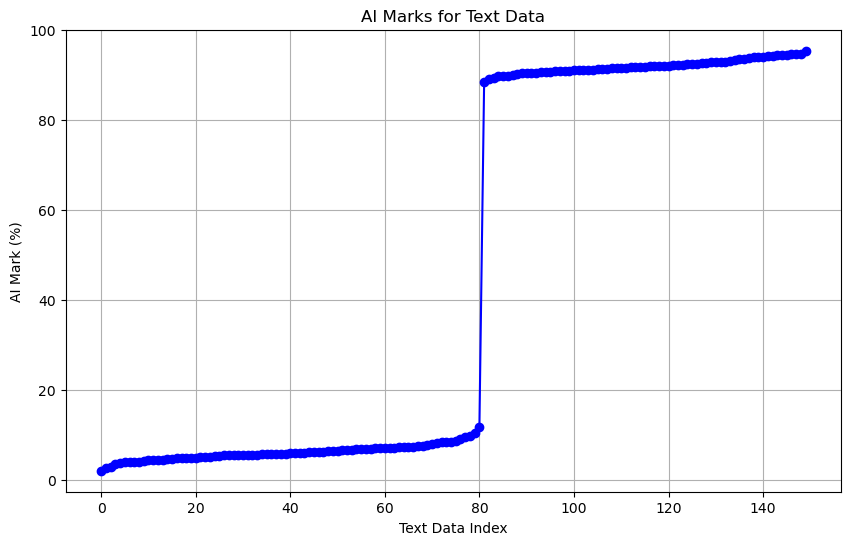

In [25]:
# Empty list to store AI marks
ai_marks = []

# Traverse the tree to collect AI marks
traverse_tree_for_graph(tree.root, ai_marks)

# Plotting the AI marks
plt.figure(figsize=(10, 6))
plt.plot(ai_marks, marker='o', linestyle='-', color='b')
plt.title('AI Marks for Text Data')
plt.xlabel('Text Data Index')
plt.ylabel('AI Mark (%)')
plt.grid(True)
plt.show()

In [26]:
import pandas as pd

# Initialize variables for true positives, false positives, true negatives, and false negatives
def calculate_metrics(text_data, target):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    
    for text, label in zip(text_data, target):
        ai_percentage, is_ai_generated = detect_ai_ensemble(text)
        predicted_label = "AI generated" if is_ai_generated else "Human generated"
        
        # True positives
        if label == "AI generated" and predicted_label == "AI generated":
            true_positives += 1
        # False positives
        elif label == "Human generated" and predicted_label == "AI generated":
            false_positives += 1
        # True negatives
        elif label == "Human generated" and predicted_label == "Human generated":
            true_negatives += 1
        # False negatives
        elif label == "AI generated" and predicted_label == "Human generated":
            false_negatives += 1
    
    # Create a DataFrame with the calculated metrics
    metrics_df = pd.DataFrame({
        "Metric": ["True Positives", "False Positives", "True Negatives", "False Negatives"],
        "Value": [true_positives, false_positives, true_negatives, false_negatives]
    })
    
    return metrics_df

# Calculate true positives, false positives, true negatives, and false negatives
metrics_df = calculate_metrics(text_data, target)

# Print the DataFrame
print(metrics_df)


            Metric  Value
0   True Positives      0
1  False Positives      0
2   True Negatives     69
3  False Negatives     81


In [27]:
import pandas as pd

# Define initial threshold and maximum iterations
initial_threshold = 20
max_iterations = 10

# Function to dynamically adjust the threshold based on metrics
def adjust_threshold(tp, fp, tn, fn, current_threshold):
    # Calculate the sensitivity (true positive rate) and specificity (true negative rate)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Calculate the new threshold based on the sensitivity and specificity
    new_threshold = current_threshold - (sensitivity - specificity) * 10
    
    # Ensure the new threshold is within the valid range [0, 100]
    new_threshold = max(0, min(new_threshold, 100))
    
    return new_threshold

# Initialize variables for true positives, false positives, true negatives, and false negatives
true_positives = false_positives = true_negatives = false_negatives = 0
current_threshold = initial_threshold

# Iterate to adjust the threshold and rebuild the tree
for i in range(max_iterations):
    # Calculate metrics using the current threshold
    metrics_df = calculate_metrics(text_data, target)
    true_positives, false_positives, true_negatives, false_negatives = metrics_df["Value"]
    
    # Adjust the threshold based on metrics
    current_threshold = adjust_threshold(true_positives, false_positives, true_negatives, false_negatives, current_threshold)
    
    # Rebuild the tree with the adjusted threshold
    tree = build_tree_from_text_with_threshold(text_data, target)

    # Print the current threshold and metrics
    print(f"Iteration {i+1}: Threshold = {current_threshold:.2f}")
    print(metrics_df)
    
    # Check for convergence (if the metrics have stabilized)
    if i > 0:
        if metrics_df.equals(prev_metrics_df):
            print("Converged. Stopping iterations.")
            break
    
    # Store the current metrics for comparison in the next iteration
    prev_metrics_df = metrics_df.copy()

# Traversing the tree and printing out the information
print("Traversing the tree:")
traverse_tree(tree.root)


Iteration 1: Threshold = 30.00
            Metric  Value
0   True Positives      0
1  False Positives      0
2   True Negatives     69
3  False Negatives     81
Iteration 2: Threshold = 40.00
            Metric  Value
0   True Positives      0
1  False Positives      0
2   True Negatives     69
3  False Negatives     81
Converged. Stopping iterations.
Traversing the tree:
Text: " This allows the exchange and its members to concentrate our marketing on the pig and live cattle contracts ," LMFE official Peter Freeman said . " These two have already shown their effectiveness for hedging , and the trade in both contracts is increasing ," he added . " Using the futures market allows better planning and forward price fixing that our industry needs ," chairman Pat Elmer said . Some 131 pig contracts were settled against the Meat and Livestock Commission ' s Average All Pigs Price in February , which represents hedging for over 13 , 000 pigs , more than twice the number cash - settled in Janua

In [28]:
ai_marks = []
traverse_tree_for_graph(tree.root, ai_marks)

# Test line: Print AI marks collected from the tree traversal
print("AI Marks collected from the tree traversal:")
print(ai_marks)

AI Marks collected from the tree traversal:
[2.117419266715488, 2.7087472780802346, 2.9551045092061057, 3.7153505769200574, 3.917291716016152, 3.9653470346716735, 4.088306735180542, 4.098826852659633, 4.141071668688875, 4.322693584904832, 4.402196217889729, 4.5520849233104705, 4.5835090951865425, 4.590490941887234, 4.673038358149462, 4.680452392300502, 4.8344770664200665, 4.843658755857785, 4.893447729432637, 4.910117683654908, 5.039524405334097, 5.104945708269102, 5.140256627065903, 5.228504770866287, 5.319830830251734, 5.455191162674308, 5.504347078368976, 5.5317697874620135, 5.532163435513871, 5.544513515165523, 5.558534479382137, 5.571751531645722, 5.604730486265324, 5.670557407164867, 5.733836311541932, 5.762626047681865, 5.801228462535106, 5.822356263545452, 5.899729976956614, 5.903592206762509, 5.952835175772645, 5.989594825340072, 6.0031622663771955, 6.14335911472749, 6.219092167501821, 6.228003359544313, 6.2467183345165855, 6.347213106353382, 6.445551053033896, 6.5110160873557

In [39]:
def detect_ai_percentage_for_input_sentence(input_sentence, tree):
    ai_percentage, is_ai_generated = detect_ai_ensemble(input_sentence)

    print (f"{ai_percentage:.2f}")

# Example usage
input_sentence = input("Enter your sentence: ")
detect_ai_percentage_for_input_sentence(input_sentence, tree)


37.76
